In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/ML

/content/gdrive/My Drive/ML


In [4]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=1b746ecec7bca3231e13644b76bc822760d27d23d3c3ea6e6be11a302d68c301
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget

In [0]:
link_pretrain_model = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
link_train_data = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip"
link_valid_data = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip"

In [0]:
wget.download(link_pretrain_model)

In [0]:
wget.download(link_train_data)

In [0]:
wget.download(link_valid_data)

In [0]:
data_train = "./train"
data_valid = "./valid"

In [0]:
!unzip -q horse-or-human.zip -d $data_train
!unzip -q validation-horse-or-human.zip -d $data_valid

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weight_file = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

preTrainModel = InceptionV3(input_shape=(200,200,3),
                            include_top = False,
                            weights = None) 
preTrainModel.load_weights(local_weight_file)

In [9]:
preTrainModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
for layer in preTrainModel.layers:
    layer.trainable = False

In [11]:
preTrainModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
pick_layers = preTrainModel.get_layer("mixed7")
pick_layers_output = pick_layers.output

In [13]:
pick_layers_output

<tf.Tensor 'mixed7/Identity:0' shape=(None, 10, 10, 768) dtype=float32>

In [0]:
x = layers.Flatten()(pick_layers_output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation = "sigmoid")(x)

In [0]:
model = Model(preTrainModel.input, x)
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["acc"])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
gen_train = ImageDataGenerator(rescale = 1/255,
                               rotation_range= 40,
                               width_shift_range = 0.4,
                               height_shift_range = 0.4,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [0]:
gen_valid = ImageDataGenerator(rescale = 1/255)

In [22]:
train_aug = gen_train.flow_from_directory(
      data_train,
      target_size = (200,200),
      class_mode = "binary",
      batch_size = 130
)

Found 1027 images belonging to 2 classes.


In [23]:
valid_aug = gen_valid.flow_from_directory(
      data_valid,
      target_size = (200,200),
      class_mode = "binary",
      batch_size = 130
)

Found 256 images belonging to 2 classes.


In [24]:
history = model.fit_generator(
      train_aug,
      validation_data = valid_aug,
      steps_per_epoch = 20,
      epochs = 20,
      validation_steps = 20,
      verbose = 1
)

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/20
20/20 [==============================] - 575s 29s/step - loss: 1.6615 - acc: 0.8368 - val_loss: 0.1644 - val_acc: 0.9805
Epoch 2/20
20/20 [==============================] - 46s 2s/step - loss: 0.1164 - acc: 0.9703 - val_loss: 0.0841 - val_acc: 0.9844
Epoch 3/20
20/20 [==============================] - 46s 2s/step - loss: 0.0506 - acc: 0.9821 - val_loss: 0.0595 - val_acc: 0.9883
Epoch 4/20
20/20 [==============================] - 46s 2s/step - loss: 0.0431 - acc: 0.9867 - val_loss: 0.0462 - val_acc: 0.9883
Epoch 5/20
20/20 [==============================] - 46s 2s/step - loss: 0.0284 - acc: 0.9899 - val_loss: 0.0441 - val_acc: 0.9883
Epoch 6/20
20/20 [==============================] - 47s 2s/step - loss: 0.0228 - acc: 0.9926 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 7/20
20/20 [==============================] - 46s 2s/step - loss: 0.0330 - acc: 0.9895 - val_loss: 0.0559 - val_acc: 0.9883
Epoch 8/20
20/20 [==============================] - 46s 2s/step - loss: 0.0218 - acc: 0.

In [0]:
model.save("classifiedHorseOrHuman_transferLearning.h5")

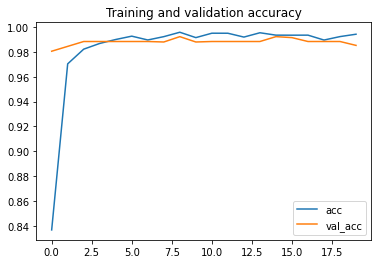

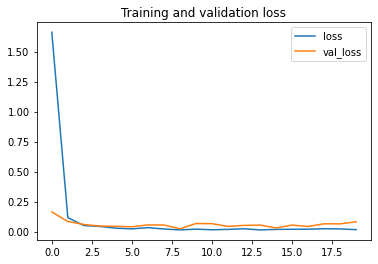

In [28]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, label = "acc")
plt.plot(epochs, val_acc, label = "val_acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label = "loss")
plt.plot(epochs, val_loss, label = "val_loss")
plt.title("Training and validation loss")
plt.legend()